In [1]:
import pandas as pd
import argparse
import logging
import json
import os
import pathlib
import fiona
import numpy as np
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from geopandas.tools import geocode
from shapely.geometry import Point
import requests
from zipfile import ZipFile
from tqdm import trange, tqdm

#import geojson

In [2]:
def get_commune_egids(BLDG_DIRECTORY, canton, commune, ZIP_URL):

    # downloading the list of EGIDs of a commune.
    # the commune must be specified using the federal numbering system (e.g. 5192 is Lugano)
    print("Downloading data from Swiss official commune register for", commune, "(BFS gemeinde-nummer)")
    url = "%s/%s/%s.zip" % (ZIP_URL, canton, commune)

    zip_name = commune + ".zip"
    file_name = commune + ".csv"
    downloaded_file = BLDG_DIRECTORY / zip_name
    downloaded_file.write_bytes(requests.get(url).content)
    print(downloaded_file)
    

    with ZipFile(downloaded_file,'r') as z:
         
        #parsing the downloaded .csv file
        with z.open(file_name) as f:
            commune_rea = pd.read_csv(f, sep=';')
            #print(commune_rea.head())
            
            commune_egid_clean = commune_rea['EGID']

            # deleting duplicated entries
            i = commune_egid_clean.duplicated(keep='first')
            commune_egid_dirty = commune_egid_clean.loc[i]
            commune_egid_dirty.reset_index(drop=True, inplace=True)
            commune_egid_clean.drop_duplicates(keep=False, inplace=True)
            
            return commune_egid_clean, commune_egid_dirty

In [3]:
def group_clean_list(list_clean, n=20):
    # creating a list for the lookup by FEATURE_ID. The entries are grouped by 20 EGIDs (max number on the server per
    # request). The FEATURE_ID is usually the EGID followed by the suffix "_0"
    temp = []
    for index, value in list_clean.items():
        temp.append(str(value) + '_0')

    list_clean_grouped = []
    for x in range(0, int(list_clean.count()), n):
        list_clean_grouped.append(','.join(temp[x:x + n]))

    return list_clean_grouped

In [4]:
def download_clean_list(list_clean_grouped, list_dirty, API_URL, DATA_LAYER):
    # downloading data by group of EGIDs
    print("Downloading data of 'clean' EGIDs")

    for index in trange(0, len(list_clean_grouped)):
        feature_id = list_clean_grouped[index]
        url = "%s/%s/%s" % (API_URL, DATA_LAYER, feature_id)
        res = requests.get(url)

        if res.status_code == 200:
            temp = json.loads(res.text)
            # jprint(temp)

            if not 'features' in temp or len(temp['features']) == 0:
                print("No data was retrieved. Please enter different inputs")
                #print('\nProgram ended')
                #exit()
        elif res.status_code == 404:

            while res.status_code == 404:
                # extrapolating the problematic EGID
                i_a = res.text.find('id')+3
                i_b = res.text.rfind("_")+2
                i_c = res.text.rfind("_")
                egid_id = res.text[i_a:i_b]

                egid_id.strip()
                list_dirty.loc[list_dirty.count()] = res.text[i_a:i_c]

                feature_id = feature_id.replace(egid_id + ',', '')
                feature_id = feature_id.replace(',' + egid_id, '')

                url = "%s/%s/%s" % (API_URL, DATA_LAYER, feature_id)
                res = requests.get(url)


        else:
            print(res.status_code)

        url = "%s/%s/%s?geometryFormat=geojson" % (API_URL, DATA_LAYER, feature_id)
        res = requests.get(url)
        temp = json.loads(res.text)
        # print(temp)
        temp_gdf = gpd.GeoDataFrame.from_features(temp)
        # print(temp_gdf)

        if index < 1:
            gdf = temp_gdf.copy()
        else:
            gdf = pd.concat([gdf,temp_gdf],ignore_index=True)

    list_dirty.drop_duplicates(keep='first', inplace=True)
    gdf.reset_index(drop=True, inplace=True)

    return gdf, list_dirty

In [5]:
def download_dirty_list(list_dirty, gdf, commune,API_URL, DATA_LAYER, SRC_FIELD):

    # downloading data by single EGID (for problematic entries)
    print("Downloading data of 'dirty' EGIDs (names that needed post-processing for retrieval)")

    with tqdm(total=list_dirty.count()) as pbar:
        for index, value in list_dirty.items():
            src_text = str(value)
            main_url = "%s/find?layer=%s&searchText=%s&searchField=%s&geometryFormat=geojson" % (API_URL, DATA_LAYER, src_text, SRC_FIELD)
            param_url = "&contains=false" #% c.SR
            url = main_url + param_url
            # print(url)
            res = requests.get(url)
            temp = json.loads(res.text)
            temp['type'] = "FeatureCollection"
            temp['features'] = temp['results']

            # jprint(temp['features'])
            if len(temp['results']) > 0:
                temp_gdf = gpd.GeoDataFrame.from_features(temp["features"])
                gdf = pd.concat([gdf,temp_gdf],ignore_index=True)

            pbar.update(1)

    gdf.reset_index(drop=True, inplace=True)
    gdf.set_crs(crs='epsg:2056', inplace=True)

    print("Download ended")

    return gdf

In [6]:
def gdf_to_file(gdf, commune,  BLDG_DIRECTORY):

    name_json = "raw-gdf-"+str(commune) +".geojson"
    filename_json = BLDG_DIRECTORY / name_json
    gdf_json = gdf.to_json(indent=4)

    with open(filename_json, "w") as text_file:
        text_file.write(gdf_json)

    name_csv = "raw-gdf-"+str(commune) +".csv"
    filename_csv = BLDG_DIRECTORY / name_csv
    gdf.to_csv(filename_csv)

    print("The dataframe containing the raw data was written to:", filename_json)

    return gdf

In [7]:
def filter_bldg_type_district(bldgs, gklas, gstat):
    bldg_res = bldgs.loc[((bldgs["gklas"]== gklas) & (bldgs["gstat"]== 1004))]
    return bldg_res

In [8]:
def get_PV_pot_bldgid(building_id):
    TOT_DATA = pd.DataFrame()
    url = 'https://api3.geo.admin.ch//rest/services/api/MapServer/find?'
    params = dict(
        layer='ch.bfe.solarenergie-eignung-daecher',
        searchField='building_id',
        searchText= building_id,
        contains='false'
    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    temp = json.loads(res.text)
    temp_3 = pd.DataFrame.from_dict(temp, orient="index")
    for i in range(len(temp_3.T)):
        POT_bldg_PV_data =  pd.DataFrame.from_dict(temp_3.iat[0,i],orient="index")
        POT_attributes = POT_bldg_PV_data.loc["attributes"].to_dict()
        POT_attr = pd.DataFrame.from_dict(POT_attributes).T
        
        POT_attr = POT_attr[['building_id', 'bedarf_heizung', 'bedarf_warmwasser', 'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag','klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']]
        
        POT_attr = POT_attr.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand',
                                             'flaeche_kollektoren':'area_collectors', 'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                                             'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        
        POT_attr = POT_attr.set_index('label')
        TOT_DATA = pd.concat([TOT_DATA, POT_attr])
    
    return TOT_DATA

In [9]:
def get_PV_pot_coords(coords):
    #print(coords)
    url = 'https://api3.geo.admin.ch/rest/services/api/MapServer/identify?'
    params = dict(
        lang= "en",
        sr='2056',
        geometryType='esriGeometryPoint',
        geometry=coords,
        imageDisplay='0,0,0',
        mapExtent='0,0,0,0',
        tolerance='0',
        limit=10,
        returnGeometry ="false",
        layers='all:ch.bfe.solarenergie-eignung-daecher'

    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    temp = json.loads(res.text)
    #print(temp)
    
    temp_2 = pd.DataFrame.from_dict(temp, orient="columns")
    temp_2.reset_index()

    bldg_PV_data =  pd.DataFrame.from_dict(temp_2.iat[0,0],orient="index")
    bldg_PV_data = bldg_PV_data.rename(columns = {0:"results"})
    #print(bldg_PV_data)
    
    if bldg_PV_data.loc["featureId","results"] == -99:
        #print("no feature at this coordinate")  
        data_fill = [-99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99,  -99, -99, -99]
        PV_POT_attr_filter = pd.DataFrame(data_fill).T
        PV_POT_attr_filter.columns = ['building_id', 'bedarf_heizung', 'bedarf_warmwasser',  'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag', 
                                         'klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']

        PV_POT_attr_filter = PV_POT_attr_filter.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand', 'flaeche_kollektoren':'area_collectors', 
                     'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                     'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        
        PV_POT_attr_filter =  PV_POT_attr_filter.set_index('label')
    else:
        attributes = bldg_PV_data.loc["attributes"].to_dict()
        PV_POT_attr = pd.DataFrame.from_dict(attributes).T

        PV_POT_attr_filter = PV_POT_attr[['building_id', 'bedarf_heizung', 'bedarf_warmwasser',  'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag', 
                                         'klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']]

        PV_POT_attr_filter = PV_POT_attr_filter.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand', 'flaeche_kollektoren':'area_collectors', 
                     'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                     'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        PV_POT_attr_filter = PV_POT_attr_filter.set_index("label")
        #PV_POT_attr_filter = PV_POT_attr_filter.drop(["index"])
        
    #print(PV_POT_attr_filter) 
    return PV_POT_attr_filter

In [10]:
# Define constants
EPSG_CODE = "EPSG:2056"
BUFFER_DISTANCE = 5
GKLAS_SFH = 1110
GKLAS_DFH = 1121
GKLAS_MFH = 1122
GKLAS_RES = [GKLAS_SFH, GKLAS_DFH, GKLAS_MFH]
GBAUP = [8011,8012,8013,8014,8015,8016,8017,8018,8019,8020,8021,8022,8023]
GSTAT = 1004 # existing

REA_CODES_DESIRED_CC = ['EGID', 'GKODE', 'GKODN',
                           'GSTAT', 'GKAT', 'GKLAS', 'GBAUJ', 'GBAUP', 'GRENJ', 'GABBJ', 'GAREA','GASTW', 
                           'GWAERZH1', 'GENH1', 'GWAERDATH1', 'GWAERZH2', 'GENH2', 'GWAERDATH2', 
                           'GWAERZW1', 'GENW1', 'GWAERDATW1','GWAERZW2', 'GENW2', 'GWAERDATW2', 
                           'Create_Date','Update_Date', 'GGDENR', 'GDENAME', 'GDEKT']

#REA_CODES_DESIRED_LC = REA_CODES_DESIRED_CC
#for i in range(len(REA_CODES_DESIRED_CC)):
#    REA_CODES_DESIRED_LC[i] = REA_CODES_DESIRED_LC[i].lower()

In [11]:
pathlib.Path()
NOTEBOOK_PATH = pathlib.Path().resolve()
p = NOTEBOOK_PATH.parent
DATA_DIRECTORY = p / "data"
MAP_DIRECTORY = DATA_DIRECTORY /'maps'
BLDG_DIRECTORY = DATA_DIRECTORY /'Buildings_rea'

#SELECT CANTON
#CANTON = "Genève"
CANTON = "Ticino"

# Read the shp file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
SWISSTOPO_DISTRICT_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_BEZIRKSGEBIET.shp" #shapefile downloaded from https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html
SWISSTOPO_CANTON_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_KANTONSGEBIET.shp" #shapefile downloaded from https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html. NOTE: The actual shapefile (.shp) is useless without the companion files: .dbf, .shx, .prj etc..
### SWISSTOPO_CANTON_FILE = figureout how to get the municipal boundaries https://api3.geo.admin.ch/rest/services/api/MapServer/ch.swisstopo.swissboundaries3d-gemeinde-flaeche.fill

CANTON_FILE_PATH = MAP_DIRECTORY / SWISSTOPO_CANTON_FILE
DISTRICT_FILE_PATH = MAP_DIRECTORY / SWISSTOPO_DISTRICT_FILE

CANTON_CSV_DIRECTORY = BLDG_DIRECTORY / CANTON

# Read the gpkg file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
PLANT_DIRECTORY = DATA_DIRECTORY /'ElectricityProduction_EPSG2056'

### Read Canton file

In [12]:
canton_raw_limits = gpd.read_file(CANTON_FILE_PATH)
canton_limits = canton_raw_limits.to_crs(epsg=2056)
canton_selection = canton_limits[canton_limits.NAME == CANTON]
canton_selection = canton_selection[["NAME", "geometry"]]
canton_selection= canton_selection.reset_index()
canton_selection.at[0,"geometry"]
print(canton_selection)

   index    NAME                                           geometry
0      4  Ticino  POLYGON Z ((2727358.511 1119219.094 1351.527, ...


### Read the Districts geometries

In [13]:
# Read the shp file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
district_raw_limits = gpd.read_file(MAP_DIRECTORY/SWISSTOPO_DISTRICT_FILE)
district_limits = district_raw_limits.to_crs(epsg=2056)
district_limits.head()

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,...,BEZIRKSNUM,SEE_FLAECH,REVISION_Q,BEZIRKSFLA,BEZIRK_TEI,NAME,KANTONSNUM,ICC,EINWOHNERZ,geometry
0,{9D91928E-115F-43DA-AF90-10625E58B7F9},2020-11-19,2012-10-26,2012,10,2023,1,Verbessert,AV,2020,...,1850,NaN,sb_2022_3D,137355.0,0,Surselva,18,CH,21438.0,"POLYGON Z ((2700578.046 1159167.279 3015.711, ..."
1,{18B8E2A0-F043-4198-87FC-119BA9F5E762},2022-10-24,2012-10-26,2012,10,2023,1,Verbessert,AV,2023,...,250,0.0,sb_2022_3D,122931.0,1,Interlaken-Oberhasli,2,CH,47811.0,"POLYGON Z ((2629760.290 1168259.810 557.681, 2..."
2,{1C504398-486E-49F8-A024-B59233F9DE89},2018-11-22,2012-10-26,2012,10,2023,1,Verbessert,AV,2019,...,1843,NaN,sb_2022_3D,119653.0,0,Engiadina Bassa/Val Müstair,18,CH,9189.0,"POLYGON Z ((2803369.136 1191207.211 3111.081, ..."
3,{FDA49AE0-D4C8-43EF-9275-0624413C5949},2020-11-19,2012-10-26,2012,10,2023,1,Verbessert,AV,2020,...,1846,NaN,sb_2022_3D,97358.0,0,Maloja,18,CH,18236.0,"POLYGON Z ((2800111.240 1150594.671 3103.606, ..."
4,{25673BF2-FF32-48E3-AA80-880EA3D4B856},2022-11-14,2012-10-26,2012,10,2023,1,Verbessert,AV,2023,...,246,NaN,sb_2022_3D,94245.0,1,Bern-Mittelland,2,CH,418807.0,"POLYGON Z ((2604676.804 1183530.496 781.881, 2..."


### filter for District

In [14]:
#TI_districts = ["Bellinzona", "Lugano", "Mendrisio", "Locarno", "Vallemaggia", "Leventina", "Blenio", "Riviera"]
#District = district_limits[district_limits['NAME'].isin(TI_districts)]
Districts = district_limits[district_limits['KANTONSNUM'] == 21]
Districts = Districts[["NAME", "geometry"]].reset_index()
Districts

,index,NAME,geometry
0,13,Locarno,"POLYGON Z ((2714379.965 1113365.731 199.628, 2..."
1,16,Vallemaggia,"POLYGON Z ((2697839.712 1117891.512 1382.656, ..."
2,23,Leventina,"POLYGON Z ((2690167.460 1159217.479 2999.313, ..."
3,31,Blenio,"POLYGON Z ((2722946.495 1150435.679 3390.416, ..."
4,32,Lugano,"POLYGON Z ((2705224.608 1096540.957 691.169, 2..."
5,54,Bellinzona,"POLYGON Z ((2727358.511 1119219.094 1351.527, ..."
6,76,Riviera,"POLYGON Z ((2716627.405 1134972.637 286.404, 2..."
7,102,Mendrisio,"POLYGON Z ((2716548.012 1080243.765 440.335, 2..."


### get the PV plants

In [15]:
## double checking raw data - according to LINK there are XXX PV plants in TI
plants =  gpd.read_file(PLANT_DIRECTORY / "ElectricityProductionPlants.gpkg") #file downloaded from https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/e5a00bdb-5022-4856-ad4a-d1afe7bf38b0
PV_DATA = pd.DataFrame()

for i in range(len(Districts)):
    plants_in_district = plants[plants.within(Districts.at[i,"geometry"])]
    PV_DATA = pd.concat([PV_DATA, plants_in_district],ignore_index=True)
    
PV_plants_in_canton = PV_DATA.loc[PV_DATA["SubCategory"]== "subcat_2"]
print(len(PV_plants_in_canton))

8226


In [16]:
PV_plants_in_canton.head()
#PV_plants_in_canton.crs

,xtf_id,Address,PostCode,Municipality,Canton,BeginningOfOperation,InitialPower,TotalPower,MainCategory,SubCategory,PlantCategory,geometry
0,17284,Fordigia 1,6647,Mergoscia,TI,2011-12-20,4.3,4.3,maincat_2,subcat_2,plantcat_8,POINT (2707783.000 1118644.000)
1,12658,Via Falò 64,6646,Contra,TI,2009-03-11,3.3,3.3,maincat_2,subcat_2,plantcat_8,POINT (2708105.000 1116344.000)
2,10798,Via Boscioredo 8,6516,Cugnasco,TI,2008-11-20,7.4,7.4,maincat_2,subcat_2,plantcat_8,POINT (2714512.000 1114816.000)
3,11299,Via Caselle 8,6644,Orselina,TI,2009-01-29,7.6,7.6,maincat_2,subcat_2,plantcat_8,POINT (2704931.000 1114890.000)
4,10978,Via ai Monti 21a,6600,Locarno,TI,2006-12-22,2.1,2.1,maincat_2,subcat_2,plantcat_8,POINT (2704566.000 1114217.000)


## 2. Getting REA data and assembling it with PV plant installed and potentials

In [18]:
REA_CODES_DESIRED_LC = ['egid', 'strname_deinr', 'ggdename', 'ggdenr',
       'gexpdat', 'gdekt', 'egrid','gebnr', 'gkode', 'gkodn', 'gksce', 'gstat', 'gkat', 'gklas',
       'gbauj', 'gbaup', 'gabbj', 'garea', 'gastw', 'gazzi', 'gebf', 'gwaerzh1',
       'genh1', 'gwaersceh1', 'gwaerdath1', 'gwaerzh2', 'genh2', 'gwaersceh2',
       'gwaerdath2', 'gwaerzw1', 'genw1', 'gwaerscew1', 'gwaerdatw1',
       'gwaerzw2', 'genw2', 'gwaerscew2', 'gwaerdatw2']

#REA_CODES_DESIRED_LC = REA_CODES_DESIRED_CC
#for i in range(len(REA_CODES_DESIRED_CC)):
#    REA_CODES_DESIRED_LC[i] = REA_CODES_DESIRED_LC[i].lower()

EGID
L’identificatore federale dell’edificio (EGID) è il numero di identificazione dell’e¬dificio in cui la persona vive ed è determinato dall’indirizzo.  L’EGID è generato dal REA e permette un’identificazione univoca dell’edificio in tutta la Svizzera.

EWID
L’identificatore federale dell’abitazione (EWID) è il numero di identificazione dell’abitazione in cui vive la persona. L’EWID è generato dal REA e, insieme all’identificatore federale dell’edificio (EGID), permette un’identificazione univoca dell’abitazione in tutta la Svizzera. Un’abitazione dispone di un’installazione per la cucina (cucina o angolo cottura).

## 2.1 run script to get data for all comunes of a desired cantone

In [107]:
ZIP_URL = 'https://data.geo.admin.ch/ch.bfs.gebaeude_wohnungs_register/CSV'
API_URL = 'https://api3.geo.admin.ch/rest/services/api/MapServer'
DATA_LAYER = 'ch.bfs.gebaeude_wohnungs_register'  # REA
SRC_FIELD = 'egid'


SFH_csv_name = "bldg_SFH_PV_EGID.csv"
DFH_csv_name = "bldg_DFH_PV_EGID.csv"
MFH_csv_name = "bldg_MFH_PV_EGID.csv"


TOT = pd.DataFrame()
REA_DATA = pd.DataFrame()
PV_plants_geo = PV_plants_in_canton.copy()
PV_plants_geo['geometry'] = PV_plants_geo['geometry'].buffer(5)


UST_file = "UST_comune.csv"
canton ="TI"
UST_comune = pd.read_csv(MAP_DIRECTORY/UST_file)
UST_comune = UST_comune[UST_comune['Cantone'] == canton].reset_index()


for num in range(len(UST_comune)-75):
    commune = str(UST_comune['Numero UST del Comune'].iloc[75+num])
    #print(commune)
    
    commune_tocsv = commune +"_"
    
    commune_SFH_csv = commune_tocsv + SFH_csv_name
    commune_DFH_csv = commune_tocsv + DFH_csv_name
    commune_MFH_csv = commune_tocsv + MFH_csv_name

    csv_names = [commune_SFH_csv, commune_DFH_csv, commune_MFH_csv]
    
    commune_egid_clean, commune_egid_dirty  = get_commune_egids(BLDG_DIRECTORY, canton, commune, ZIP_URL)
    commune_egid_clean_grouped = group_clean_list(commune_egid_clean)
    gdf, commune_egid_dirty = download_clean_list(commune_egid_clean_grouped, commune_egid_dirty, API_URL, DATA_LAYER)
    gdf = download_dirty_list(commune_egid_dirty, gdf, commune,API_URL, DATA_LAYER, SRC_FIELD)
    gdf_to_file(gdf, commune, BLDG_DIRECTORY)

    bldgs = gdf[REA_CODES_DESIRED_LC]


    #geopanda - create points geometry from GKODE and GKODN
    bldg_geo = gpd.GeoDataFrame(bldgs, geometry=gpd.points_from_xy(bldgs.gkode, bldgs.gkodn))
    #bldg_geo = gpd.GeoDataFrame(bldgs)

    # call function filter_bldg_type_district to get the buildings
    bldg_district_SFH = filter_bldg_type_district(bldg_geo, GKLAS_SFH, GSTAT)
    bldg_district_DFH = filter_bldg_type_district(bldg_geo, GKLAS_DFH, GSTAT)
    bldg_district_MFH = filter_bldg_type_district(bldg_geo, GKLAS_MFH, GSTAT)
        

    n=0
    for res_type in (bldg_district_SFH, bldg_district_DFH, bldg_district_MFH):
        csv_name = csv_names[n]
        #print(csv_name)

        bldg_PP = res_type.copy()
        bldg_PP = bldg_PP[["egid","geometry"]]
        bldg_PP = bldg_PP.set_crs("EPSG:2056")
        bldg_PP = gpd.sjoin(bldg_PP, PV_plants_geo)

        geo = res_type.reset_index()
        # print(geo.head())
    
        ## iterate for each bldg in the bldg type SFH, DFH, MFH and find their roof area and PV potential from the geoadmin.ch site.

        for i in range(len(geo)): ##range(len(geo)) to iterate over all bldgs, otherwise range(5) if only testing that it works
            assert type(geo.loc[i, 'geometry']) == Point, "Your geometry is not of Point type. It is" % type(geo['geometry'])
            coords = str(geo.loc[i, 'geometry'].x) + "," + str(geo.loc[i, 'geometry'].y)
            coords_PV_pot = get_PV_pot_coords(coords)

            if coords_PV_pot.iat[0,0]==-99:
                bldg_PV_pot = coords_PV_pot.reset_index()

            else:
                building_id = str(coords_PV_pot.iat[0,0])
                bldg_PV_pot = get_PV_pot_bldgid(building_id)
                bldg_PV_pot = bldg_PV_pot.reset_index()


            geo_i = geo.loc[[i]]
            geo_i = geo_i.reset_index()
            joint_df = bldg_PV_pot.join(geo_i)
            joint_df["str_geometry"] = joint_df['geometry'].astype(str)
            joint_df_geo = joint_df['geometry']

            drop_list =["index","GBAUJ", "GWAERZH2","GENH2", "GWAERDATH2","GWAERZW2","GENW2","GWAERDATW2","geometry"]
            
            for m in range(len(drop_list)):
                drop_list[m] = drop_list[m].lower()

            joint_df = joint_df.drop(drop_list, axis=1) 
            joint_df = joint_df.ffill(axis="index").bfill(axis="index")
            TOT = pd.concat([TOT,joint_df], ignore_index=True)

        TOT = TOT.join(bldg_PP.set_index('egid'), on='egid', validate='m:m')
        TOT.to_csv(csv_name)
        print("done with: ", csv_name ) 
        n=n+1
        TOT = TOT.drop(['geometry',"index_right","xtf_id","Address","PostCode","Municipality","Canton","BeginningOfOperation","InitialPower","TotalPower","MainCategory","SubCategory","PlantCategory"], axis=1)
        TOT = TOT[0:0]  

C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5233.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.16it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5233.geojson
done with:  5233_bldg_SFH_PV_EGID.csv
done with:  5233_bldg_DFH_PV_EGID.csv
done with:  5233_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5236.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:36<00:00,  2.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  8.79it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5236.geojson
done with:  5236_bldg_SFH_PV_EGID.csv
done with:  5236_bldg_DFH_PV_EGID.csv
done with:  5236_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5237.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:22<00:00,  3.07it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  8.90it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5237.geojson
done with:  5237_bldg_SFH_PV_EGID.csv
done with:  5237_bldg_DFH_PV_EGID.csv
done with:  5237_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5238.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:53<00:00,  2.98it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.76it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5238.geojson
done with:  5238_bldg_SFH_PV_EGID.csv
done with:  5238_bldg_DFH_PV_EGID.csv
done with:  5238_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5239.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:46<00:00,  2.66it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  8.18it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5239.geojson
done with:  5239_bldg_SFH_PV_EGID.csv
done with:  5239_bldg_DFH_PV_EGID.csv
done with:  5239_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5240.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:20<00:00,  3.31it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.32it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5240.geojson
done with:  5240_bldg_SFH_PV_EGID.csv
done with:  5240_bldg_DFH_PV_EGID.csv
done with:  5240_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5242.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.22it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00,  9.80it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5242.geojson
done with:  5242_bldg_SFH_PV_EGID.csv
done with:  5242_bldg_DFH_PV_EGID.csv
done with:  5242_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5249.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:24<00:00,  2.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.31it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5249.geojson
done with:  5249_bldg_SFH_PV_EGID.csv
done with:  5249_bldg_DFH_PV_EGID.csv
done with:  5249_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5250.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:21<00:00,  3.14it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:09<00:00,  8.78it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5250.geojson
done with:  5250_bldg_SFH_PV_EGID.csv
done with:  5250_bldg_DFH_PV_EGID.csv
done with:  5250_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5251.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:17<00:00,  3.08it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5251.geojson
done with:  5251_bldg_SFH_PV_EGID.csv
done with:  5251_bldg_DFH_PV_EGID.csv
done with:  5251_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5254.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:48<00:00,  2.87it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:17<00:00,  7.84it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5254.geojson
done with:  5254_bldg_SFH_PV_EGID.csv
done with:  5254_bldg_DFH_PV_EGID.csv
done with:  5254_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5257.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:23<00:00,  3.02it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.53it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5257.geojson
done with:  5257_bldg_SFH_PV_EGID.csv
done with:  5257_bldg_DFH_PV_EGID.csv
done with:  5257_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5260.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.04it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  8.17it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5260.geojson
done with:  5260_bldg_SFH_PV_EGID.csv
done with:  5260_bldg_DFH_PV_EGID.csv
done with:  5260_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5263.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:22<00:00,  2.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.11it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5263.geojson
done with:  5263_bldg_SFH_PV_EGID.csv
done with:  5263_bldg_DFH_PV_EGID.csv
done with:  5263_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5266.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:28<00:00,  3.03it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.79it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5266.geojson
done with:  5266_bldg_SFH_PV_EGID.csv
done with:  5266_bldg_DFH_PV_EGID.csv
done with:  5266_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5268.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.79it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5268.geojson
done with:  5268_bldg_SFH_PV_EGID.csv
done with:  5268_bldg_DFH_PV_EGID.csv
done with:  5268_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5269.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.05it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.74it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5269.geojson
done with:  5269_bldg_SFH_PV_EGID.csv
done with:  5269_bldg_DFH_PV_EGID.csv
done with:  5269_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5281.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:56<00:00,  3.04it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:07<00:00,  8.61it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5281.geojson
done with:  5281_bldg_SFH_PV_EGID.csv
done with:  5281_bldg_DFH_PV_EGID.csv
done with:  5281_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5287.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:54<00:00,  3.04it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.94it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5287.geojson
done with:  5287_bldg_SFH_PV_EGID.csv
done with:  5287_bldg_DFH_PV_EGID.csv
done with:  5287_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5304.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.61it/s]


0it [00:00, ?it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5304.geojson
done with:  5304_bldg_SFH_PV_EGID.csv
done with:  5304_bldg_DFH_PV_EGID.csv
done with:  5304_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5307.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.08it/s]


0it [00:00, ?it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5307.geojson
done with:  5307_bldg_SFH_PV_EGID.csv
done with:  5307_bldg_DFH_PV_EGID.csv
done with:  5307_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5309.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.11it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.55it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5309.geojson
done with:  5309_bldg_SFH_PV_EGID.csv
done with:  5309_bldg_DFH_PV_EGID.csv
done with:  5309_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5310.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:32<00:00,  3.10it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.89it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5310.geojson
done with:  5310_bldg_SFH_PV_EGID.csv
done with:  5310_bldg_DFH_PV_EGID.csv
done with:  5310_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5315.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.93it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.48it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5315.geojson
done with:  5315_bldg_SFH_PV_EGID.csv
done with:  5315_bldg_DFH_PV_EGID.csv
done with:  5315_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5317.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [01:11<00:00,  3.02it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.68it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5317.geojson
done with:  5317_bldg_SFH_PV_EGID.csv
done with:  5317_bldg_DFH_PV_EGID.csv
done with:  5317_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5323.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:38<00:00,  3.11it/s]


0it [00:00, ?it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5323.geojson
done with:  5323_bldg_SFH_PV_EGID.csv
done with:  5323_bldg_DFH_PV_EGID.csv
done with:  5323_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5324.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  3.02it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.97it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5324.geojson
done with:  5324_bldg_SFH_PV_EGID.csv
done with:  5324_bldg_DFH_PV_EGID.csv
done with:  5324_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5396.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  8.44it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5396.geojson
done with:  5396_bldg_SFH_PV_EGID.csv
done with:  5396_bldg_DFH_PV_EGID.csv
done with:  5396_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5397.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:42<00:00,  2.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.03it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5397.geojson
done with:  5397_bldg_SFH_PV_EGID.csv
done with:  5397_bldg_DFH_PV_EGID.csv
done with:  5397_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5398.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [01:33<00:00,  3.03it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:05<00:00,  7.68it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5398.geojson
done with:  5398_bldg_SFH_PV_EGID.csv
done with:  5398_bldg_DFH_PV_EGID.csv
done with:  5398_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5399.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:51<00:00,  3.43it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.40it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-5399.geojson
done with:  5399_bldg_SFH_PV_EGID.csv
done with:  5399_bldg_DFH_PV_EGID.csv
done with:  5399_bldg_MFH_PV_EGID.csv


## 2.2 Putting together REA- PV plants, and PV potential for the problematic communes

In [19]:
ZIP_URL = 'https://data.geo.admin.ch/ch.bfs.gebaeude_wohnungs_register/CSV'
API_URL = 'https://api3.geo.admin.ch/rest/services/api/MapServer'
DATA_LAYER = 'ch.bfs.gebaeude_wohnungs_register'  # REA
SRC_FIELD = 'egid'

SFH_csv_name = "bldg_SFH_PV_EGID.csv"
DFH_csv_name = "bldg_DFH_PV_EGID.csv"
MFH_csv_name = "bldg_MFH_PV_EGID.csv"

TOT = pd.DataFrame()
REA_DATA = pd.DataFrame()
PV_plants_geo = PV_plants_in_canton.copy()
PV_plants_geo['geometry'] = PV_plants_geo['geometry'].buffer(5)

canton ="TI"
commune_missing = [5207,5231,5136]

for commune_num in commune_missing:
    commune = str(commune_num)
    print(commune)
    
    commune_tocsv = commune +"_"
    
    commune_SFH_csv = commune_tocsv + SFH_csv_name
    commune_DFH_csv = commune_tocsv + DFH_csv_name
    commune_MFH_csv = commune_tocsv + MFH_csv_name

    csv_names = [commune_SFH_csv, commune_DFH_csv, commune_MFH_csv]
    commune_egid_clean, commune_egid_dirty  = get_commune_egids(BLDG_DIRECTORY, canton, commune, ZIP_URL)

    DATA = pd.DataFrame()

    # specify the base URL for the API endpoint
    base_url = "https://api3.geo.admin.ch/rest/services/api/MapServer/find?"

    commune_egid_clean =commune_egid_clean.reset_index()

    for egids in range(len(commune_egid_clean)):
        egid = commune_egid_clean.loc[egids]
        #print("the eigds is ", egid)

        # specify the parameters for the API request
        params = dict(
        layer= "ch.bfs.gebaeude_wohnungs_register",
        searchText= egid,
        searchField= "egid",
        contains="false"
        )

        # make the API request and convert the response to a JSON object
        res = requests.get(base_url, params=params)
        #print (res.status_code)

        if res.status_code == 200:
            temp = json.loads(res.text)
            temp_3 = pd.DataFrame.from_dict(temp, orient="index")

            for s in range(len(temp_3.T)):
                data =  pd.DataFrame.from_dict(temp_3.iat[0,s],orient="index")
                attributes = data.loc["attributes"].to_dict()
                attr = pd.DataFrame.from_dict(attributes).T
               # print(attr["egid"])


        attr = attr.set_index('label')
        DATA = pd.concat([DATA, attr])

    DATA_name = "DATA_"+str(commune)+".csv"

    DATA.to_csv(DATA_name)

    DATA=DATA.reset_index()
    bldgs = DATA[REA_CODES_DESIRED_LC]


    #geopanda - create points geometry from GKODE and GKODN
    bldg_geo = gpd.GeoDataFrame(bldgs, geometry=gpd.points_from_xy(bldgs.gkode, bldgs.gkodn))
    #bldg_geo = gpd.GeoDataFrame(bldgs)

    # call function filter_bldg_type_district to get the buildings
    bldg_district_SFH = filter_bldg_type_district(bldg_geo, GKLAS_SFH, GSTAT)
    bldg_district_DFH = filter_bldg_type_district(bldg_geo, GKLAS_DFH, GSTAT)
    bldg_district_MFH = filter_bldg_type_district(bldg_geo, GKLAS_MFH, GSTAT)


    n=0
    for res_type in (bldg_district_SFH, bldg_district_DFH, bldg_district_MFH):
        csv_name = csv_names[n]
        #print(csv_name)

        bldg_PP = res_type.copy()
        bldg_PP = bldg_PP[["egid","geometry"]]
        bldg_PP = bldg_PP.set_crs("EPSG:2056")
        bldg_PP = gpd.sjoin(bldg_PP, PV_plants_geo)

        geo = res_type.reset_index()
        # print(geo.head())

        ## iterate for each bldg in the bldg type SFH, DFH, MFH and find their roof area and PV potential from the geoadmin.ch site.

        for i in range(len(geo)): ##range(len(geo)) to iterate over all bldgs, otherwise range(5) if only testing that it works
            assert type(geo.loc[i, 'geometry']) == Point, "Your geometry is not of Point type. It is" % type(geo['geometry'])
            coords = str(geo.loc[i, 'geometry'].x) + "," + str(geo.loc[i, 'geometry'].y)
            coords_PV_pot = get_PV_pot_coords(coords)

            if coords_PV_pot.iat[0,0]==-99:
                bldg_PV_pot = coords_PV_pot.reset_index()

            else:
                building_id = str(coords_PV_pot.iat[0,0])
                bldg_PV_pot = get_PV_pot_bldgid(building_id)
                bldg_PV_pot = bldg_PV_pot.reset_index()


            geo_i = geo.loc[[i]]
            geo_i = geo_i.reset_index()
            #print(geo_i)
            #print(bldg_PV_pot)
            joint_df = bldg_PV_pot.join(geo_i)
            joint_df["str_geometry"] = joint_df['geometry'].astype(str)
            joint_df_geo = joint_df['geometry']

            drop_list =["index","GBAUJ", "GWAERZH2","GENH2", "GWAERDATH2","GWAERZW2","GENW2","GWAERDATW2","geometry"]

            for m in range(len(drop_list)):
                drop_list[m] = drop_list[m].lower()

            joint_df = joint_df.drop(drop_list, axis=1) 
            joint_df = joint_df.ffill(axis="index").bfill(axis="index")
            TOT = pd.concat([TOT,joint_df], ignore_index=True)

        TOT = TOT.join(bldg_PP.set_index('egid'), on='egid', validate='m:m')
        TOT.to_csv(csv_name)
        print("done with: ", csv_name ) 
        n=n+1
        TOT = TOT.drop(['geometry',"index_right","xtf_id","Address","PostCode","Municipality","Canton","BeginningOfOperation","InitialPower","TotalPower","MainCategory","SubCategory","PlantCategory"], axis=1)
        TOT = TOT[0:0]  

5207
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5207.zip
done with:  5207_bldg_SFH_PV_EGID.csv
done with:  5207_bldg_DFH_PV_EGID.csv
done with:  5207_bldg_MFH_PV_EGID.csv
5231
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5231.zip
done with:  5231_bldg_SFH_PV_EGID.csv
done with:  5231_bldg_DFH_PV_EGID.csv
done with:  5231_bldg_MFH_PV_EGID.csv
5136
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\5136.zip
done with:  5136_bldg_SFH_PV_EGID.csv
done with:  5136_bldg_DFH_PV_EGID.csv
done with:  5136_bldg_MFH_PV_EGID.csv


### 2.3 Aggregate data to district and canton 

In [45]:
from pathlib import Path

SFH_TOT = pd.DataFrame()
DFH_TOT = pd.DataFrame()
MFH_TOT = pd.DataFrame()

SFH_DIS = pd.DataFrame()
DFH_DIS = pd.DataFrame()
MFH_DIS = pd.DataFrame()

UST_file = "UST_comune.csv"
canton ="TI"
UST_comune = pd.read_csv(MAP_DIRECTORY/UST_file)
UST_comune = UST_comune[UST_comune['Cantone'] == canton].reset_index()
UST_district = UST_comune['Numero del Distretto'].drop_duplicates().reset_index(drop=True)
#UST_district_num = UST_district.drop_duplicates().reset_index(drop=True)
#commune_num = UST_comune['Numero UST del Comune'].iloc[0]
    
for dis in range(len(UST_district)):
    commune_num = UST_comune[UST_comune['Numero del Distretto']== UST_district.iloc[dis]].reset_index(drop=True)
                             
    for comm in range(len(commune_num)):
        
        commune = str(commune_num['Numero UST del Comune'].iloc[comm])

        SFH_csv = str(commune) + "_bldg_SFH_PV_EGID.csv"
        DFH_csv = str(commune) + "_bldg_DFH_PV_EGID.csv"
        MFH_csv = str(commune) + "_bldg_MFH_PV_EGID.csv"

        commune_file = Path(CANTON_CSV_DIRECTORY/SFH_csv)

        if commune_file.is_file():
            SFH_pd = pd.read_csv(CANTON_CSV_DIRECTORY/SFH_csv)
            DFH_pd = pd.read_csv(CANTON_CSV_DIRECTORY/DFH_csv)
            MFH_pd = pd.read_csv(CANTON_CSV_DIRECTORY/MFH_csv)
            
            SFH_DIS = pd.concat([SFH_DIS,SFH_pd], ignore_index=True) 
            DFH_DIS = pd.concat([DFH_DIS,DFH_pd], ignore_index=True) 
            MFH_DIS = pd.concat([MFH_DIS,MFH_pd], ignore_index=True) 


            SFH_TOT = pd.concat([SFH_TOT,SFH_pd], ignore_index=True) 
            DFH_TOT = pd.concat([DFH_TOT,DFH_pd], ignore_index=True) 
            MFH_TOT = pd.concat([MFH_TOT,MFH_pd], ignore_index=True) 

        else:
            print(commune_num, "this file does not exists")  

        
    district = str(UST_district.iloc[dis])
    SFH_district_tocsv = district +"_SFH.csv"
    DFH_district_tocsv = district +"_DFH.csv"
    MFH_district_tocsv = district +"_MFH.csv"
    
    SFH_DIS.to_csv(SFH_district_tocsv)
    DFH_DIS.to_csv(DFH_district_tocsv)
    MFH_DIS.to_csv(MFH_district_tocsv)
    
    print("done with:",  UST_district.iloc[dis])
    SFH_DIS = SFH_DIS.iloc[0:0]
    DFH_DIS = DFH_DIS.iloc[0:0]
    MFH_DIS = MFH_DIS.iloc[0:0]

SFH_CANTON_tocsv = canton + "_SFH.csv"
DFH_CANTON_tocsv = canton + "_DFH.csv"
MFH_CANTON_tocsv = canton + "_MFH.csv"
    
SFH_TOT.to_csv(SFH_CANTON_tocsv)
DFH_TOT.to_csv(DFH_CANTON_tocsv)
MFH_TOT.to_csv(MFH_CANTON_tocsv)

done with: 2101
done with: 2102
done with: 2103
done with: 2104
done with: 2105
done with: 2106
done with: 2107
done with: 2108


### 2.4 Getting data for graphics

### Graphics for canton

In [47]:
SFH_CANTON_tocsv = canton + "_SFH.csv"
DFH_CANTON_tocsv = canton + "_DFH.csv"
MFH_CANTON_tocsv = canton + "_MFH.csv"

SFH = pd.read_csv(CANTON_CSV_DIRECTORY/SFH_CANTON_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])
DFH = pd.read_csv(CANTON_CSV_DIRECTORY/DFH_CANTON_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])
MFH = pd.read_csv(CANTON_CSV_DIRECTORY/MFH_CANTON_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])

CANTON_RES = pd.concat([SFH, DFH, MFH],ignore_index= True)

In [48]:
CANTON_RES = CANTON_RES.drop_duplicates(subset=['egid'])
CANTON_RES_GEO = gpd.GeoDataFrame(CANTON_RES, geometry=gpd.points_from_xy(CANTON_RES.gkode, CANTON_RES.gkodn))
CANTON_RES_GEO.head()

,egid,gkode,gkodn,str_geometry,geometry
0,11105003,2724232.580,1120786.390,POINT (2724232.58 1120786.39),POINT (2724232.580 1120786.390)
4,11105004,2723925.473,1119284.121,POINT (2723925.473 1119284.121),POINT (2723925.473 1119284.121)
7,11105005,2723913.500,1119293.970,POINT (2723913.5 1119293.97),POINT (2723913.500 1119293.970)
11,11105010,2724086.950,1120480.930,POINT (2724086.95 1120480.93),POINT (2724086.950 1120480.930)
18,11105011,2723576.940,1120951.930,POINT (2723576.94 1120951.93),POINT (2723576.940 1120951.930)


In [49]:
CANTON_RES_GEO.dtypes

egid               int64
gkode            float64
gkodn            float64
str_geometry      object
geometry        geometry
dtype: object

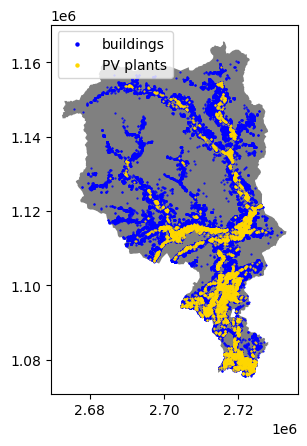

In [42]:
axes = canton_selection.plot(facecolor="grey")
CANTON_RES_GEO.plot(ax=axes, color="blue",markersize=0.3, label= "buildings")
PV_plants_in_canton.plot(ax=axes, color="gold",markersize=0.3, label="PV plants")
axes.legend(loc="upper left", markerscale=4)

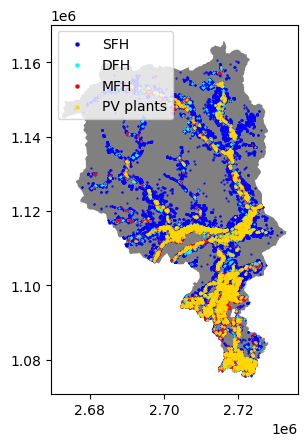

In [72]:
CANTON_RES_SFH = SFH.drop_duplicates(subset=['egid'])
CANTON_RES_SFH_GEO = gpd.GeoDataFrame(CANTON_RES_SFH, geometry=gpd.points_from_xy(CANTON_RES_SFH.gkode, CANTON_RES_SFH.gkodn))

CANTON_RES_DFH = DFH.drop_duplicates(subset=['egid'])
CANTON_RES_DFH_GEO = gpd.GeoDataFrame(CANTON_RES_DFH, geometry=gpd.points_from_xy(CANTON_RES_DFH.gkode, CANTON_RES_DFH.gkodn))

CANTON_RES_MFH = MFH.drop_duplicates(subset=['egid'])
CANTON_RES_MFH_GEO = gpd.GeoDataFrame(CANTON_RES_MFH, geometry=gpd.points_from_xy(CANTON_RES_MFH.gkode, CANTON_RES_MFH.gkodn))

axes = canton_selection.plot(facecolor="grey")
CANTON_RES_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
CANTON_RES_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
CANTON_RES_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
PV_plants_in_canton.plot(ax=axes, color="gold",markersize=0.3,label="PV plants")
axes.legend(loc="upper left", markerscale=4)

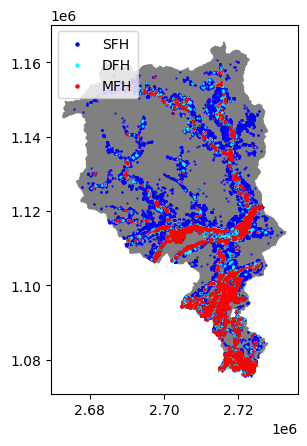

In [73]:
#import matplotlib.pyplot as plt
axes = canton_selection.plot(facecolor="grey")
CANTON_RES_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
CANTON_RES_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
CANTON_RES_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
axes.legend(loc="upper left", markerscale=4)

### Graphics for districts

In [52]:
#create directory for the Canton district data files
from pathlib import Path

## enter UST_number of desired district
DISTRICT = "2101"

DISTRICT_CSV_DIRECTORY = BLDG_DIRECTORY / CANTON / DISTRICT
Path(DISTRICT_CSV_DIRECTORY).mkdir(parents=True, exist_ok=True)

In [66]:
## enter UST_number of desired district
DISTRICT = "2101"

SFH_district_tocsv = DISTRICT + "_SFH.csv"
DFH_district_tocsv = DISTRICT + "_DFH.csv"
MFH_district_tocsv = DISTRICT + "_MFH.csv"


DISTRICT_SFH = pd.read_csv(CANTON_CSV_DIRECTORY/SFH_district_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])
DISTRICT_DFH = pd.read_csv(CANTON_CSV_DIRECTORY/DFH_district_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])
DISTRICT_MFH = pd.read_csv(CANTON_CSV_DIRECTORY/MFH_district_tocsv,  usecols= ['egid', 'gkode','gkodn','str_geometry'])

DISTRICT_RES = pd.concat([DISTRICT_SFH,DISTRICT_DFH ,DISTRICT_MFH],ignore_index= True)

DISTRICT_RES = DISTRICT_RES.drop_duplicates(subset=['egid'])
DISTRICT_RES_GEO = gpd.GeoDataFrame(DISTRICT_RES, geometry=gpd.points_from_xy(DISTRICT_RES.gkode, DISTRICT_RES.gkodn))

DISTRICT_RES_SFH = DISTRICT_SFH.drop_duplicates(subset=['egid'])
DISTRICT_RES_SFH_GEO = gpd.GeoDataFrame(DISTRICT_RES_SFH, geometry=gpd.points_from_xy(DISTRICT_RES_SFH.gkode, DISTRICT_RES_SFH.gkodn))

DISTRICT_RES_DFH = DISTRICT_DFH.drop_duplicates(subset=['egid'])
DISTRICT_RES_DFH_GEO = gpd.GeoDataFrame(DISTRICT_RES_DFH, geometry=gpd.points_from_xy(DISTRICT_RES_DFH.gkode, DISTRICT_RES_DFH.gkodn))

DISTRICT_RES_MFH = DISTRICT_MFH.drop_duplicates(subset=['egid'])
DISTRICT_RES_MFH_GEO = gpd.GeoDataFrame(DISTRICT_RES_MFH, geometry=gpd.points_from_xy(DISTRICT_RES_MFH.gkode, DISTRICT_RES_MFH.gkodn))

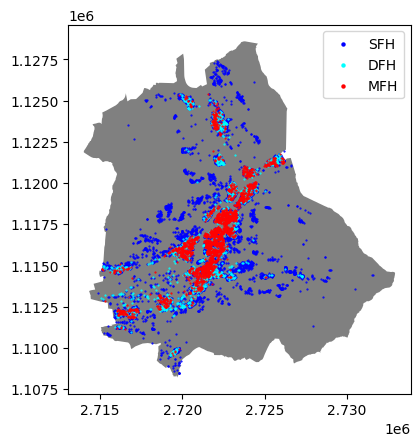

In [67]:


# Read the shp file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
SWISSTOPO_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_BEZIRKSGEBIET.shp" #shapefile downloaded from https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html
FILE_PATH = MAP_DIRECTORY / SWISSTOPO_FILE
raw_limits = gpd.read_file(FILE_PATH)
district_limits = raw_limits.to_crs(epsg=2056)

## write a line that looks for the name based on the BEZIRKSNUM
DISTRICT_NAME = "Bellinzona"
district_selection = district_limits[district_limits.NAME == DISTRICT_NAME]

district_selection = district_selection[["NAME", "geometry"]]


axes = district_selection.plot(facecolor="grey")
DISTRICT_RES_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
DISTRICT_RES_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
DISTRICT_RES_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
axes.legend(loc="upper right", markerscale=4)

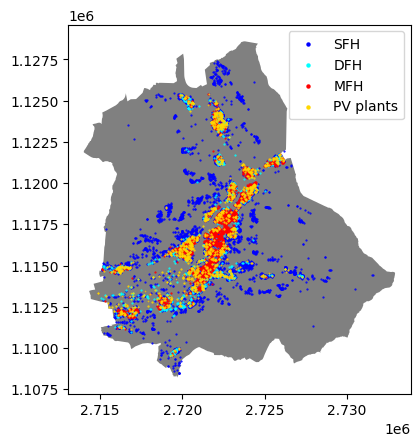

In [68]:
PLANT_DIRECTORY = DATA_DIRECTORY /'ElectricityProduction_EPSG2056'
plants =  gpd.read_file(PLANT_DIRECTORY / "ElectricityProductionPlants.gpkg") #file downloaded from https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/e5a00bdb-5022-4856-ad4a-d1afe7bf38b0
plants_in_district = plants[plants.within(district_selection.at[54,"geometry"])]
PV_plants_in_district = plants_in_district.loc[plants_in_district["SubCategory"]== "subcat_2"] 

axes = district_selection.plot(facecolor="grey")
DISTRICT_RES_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
DISTRICT_RES_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
DISTRICT_RES_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
PV_plants_in_district.plot(ax=axes, color="gold",markersize=0.3,label="PV plants")
axes.legend(loc="upper right", markerscale=4)

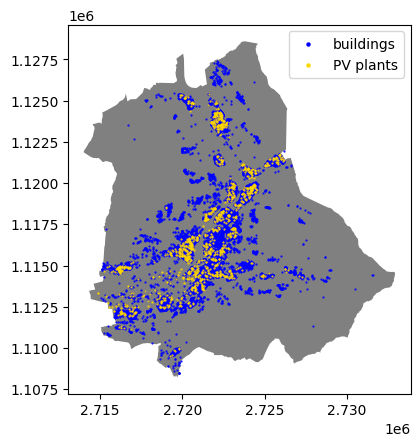

In [69]:
axes = district_selection.plot(facecolor="grey")
DISTRICT_RES_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "buildings")
PV_plants_in_district.plot(ax=axes, color="gold",markersize=0.3,label="PV plants")
axes.legend(loc="best", markerscale=4)